<a href="https://colab.research.google.com/github/Ranjani94/Advanced_Deep_Learning/blob/master/Assignment_4/Meta_Learning_omniglot_Prototype_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Omniglot Character Set Classification Using Prototypical Network

We will see how to use prototypical networks to perform the classification task. Omniglot dataset is used for performing classification. Omniglot dataset comprises of 1,623 handwritten characters from 50 different alphabets and each character has 20 different examples written by different people. Since we want our network to learn from little data, we train them in the same way. We sample five examples from each class and use that as our support set. We learn the embeddings of our support set using a sequence of four convolution blocks as our encoder and build the class prototype. Similarly, we sample five examples from each class for query set, learn the query set embeddings and predict the query set class by comparing the Euclidean distance between the query set embeddings and class prototype. Let us better understand this by going through it step by step.

### Mounting drive


In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
pip install tensorflow==1.14

In [3]:
import os
import glob
from PIL import Image

import numpy as np
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

### Tibetan

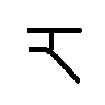

In [4]:
Image.open('/content/gdrive/My Drive/advanced_DL/datasets/data/images/Tibetan/character42/1597_18.png')

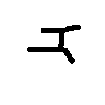

In [5]:
Image.open('/content/gdrive/My Drive/advanced_DL/datasets/data/images/Tibetan/character42/1597_13.png')

### Sanskrit

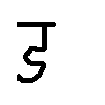

In [6]:
Image.open('/content/gdrive/My Drive/advanced_DL/datasets/data/images/Sanskrit/character13/0863_09.png')

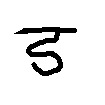

In [7]:
Image.open('/content/gdrive/My Drive/advanced_DL/datasets/data/images/Sanskrit/character13/0863_13.png')

Used np.array function to convert these images into an array and then we reshape it to 28*28

In [8]:
image_name = '/content/gdrive/My Drive/advanced_DL/datasets/data/images/Sanskrit/character13/0863_13.png'
alphabet, character, rotation = 'Sanskrit/character13/rot000'.split('/')
rotation = float(rotation[3:])

In [9]:
np.array(Image.open(image_name).rotate(rotation).resize((28, 28)), np.float32,copy=True)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1

In [10]:

root_dir = '/content/gdrive/My Drive/advanced_DL/datasets/data/'

We have the splitting details in the /data/omniglot/splits/train.txt file which has the language name, character number, rotation information and images in /data/omniglot/data/ directory.

In [11]:
train_split_path = os.path.join(root_dir, 'splits', 'train.txt')

with open(train_split_path, 'r') as train_split:
    train_classes = [line.rstrip() for line in train_split.readlines()]

In [12]:
#number of classes
no_of_classes = len(train_classes)

In [13]:
#number of examples
num_examples = 20

#image width
img_width = 28

#image height
img_height = 28
channels = 1

In [14]:
train_dataset = np.zeros([no_of_classes, num_examples, img_height, img_width], dtype=np.float32)

we read all the images, convert it to numpy array and store it our train_dataset array with their label and values, that is, train_dataset = [label, values]:



In [15]:
for label, name in enumerate(train_classes):
    alphabet, character, rotation = name.split('/')
    rotation = float(rotation[3:])
    img_dir = os.path.join(root_dir, 'data', alphabet, character)
    img_files = sorted(glob.glob(os.path.join(img_dir, '*.png')))
  
    
    for index, img_file in enumerate(img_files):
        values = 1. - np.array(Image.open(img_file).rotate(rotation).resize((img_width, img_height)), np.float32, copy=False)
        train_dataset[label, index] = values


In [16]:
train_dataset.shape

(4112, 20, 28, 28)

Now that we have loaded our training data, we need to create embeddings for them. We generate the embeddings using a convolution operation as our inputs are images. So, we define a convolutional block with 64 filters with batch normalization and ReLU as the activation function. Followed by we perform max pooling operation:

In [17]:
def convolution_block(inputs, out_channels, name='conv'):

    conv = tf.layers.conv2d(inputs, out_channels, kernel_size=3, padding='SAME')
    conv = tf.contrib.layers.batch_norm(conv, updates_collections=None, decay=0.99, scale=True, center=True)
    conv = tf.nn.relu(conv)
    conv = tf.contrib.layers.max_pool2d(conv, 2)
    
    return conv

In [18]:
def get_embeddings(support_set, h_dim, z_dim, reuse=False):

        net = convolution_block(support_set, h_dim)
        net = convolution_block(net, h_dim)
        net = convolution_block(net, h_dim) 
        net = convolution_block(net, z_dim) 
        net = tf.contrib.layers.flatten(net)
        
        return net

 we define some of the important variables, we consider a 60-way 5-shot learning scenario:

In [19]:
#number of classes
num_way = 60  

#number of examples per class for support set
num_shot = 5  

#number of query points
num_query = 5 

#number of examples
num_examples = 20

h_dim = 64

z_dim = 64

In [20]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

we initialize placeholders for our support set and query set. we store the shape of our support set and query set in support_set_shape and query_set_shape respectively. Get the number of classes and number of data points in the support set and number of data points in the query set for initializing our support and query sets. 

In [21]:
support_set = tf.placeholder(tf.float32, [None, None, img_height, img_width, channels])
query_set = tf.placeholder(tf.float32, [None, None, img_height, img_width, channels])


In [22]:
support_set_shape = tf.shape(support_set)
query_set_shape = tf.shape(query_set)

In [23]:
num_classes, num_support_points = support_set_shape[0], support_set_shape[1]

In [24]:
num_query_points = query_set_shape[1]

In [25]:
y = tf.placeholder(tf.int64, [None, None])

#convert the label to one hot
y_one_hot = tf.one_hot(y, depth=num_classes)

we generate the embeddings for our support set using our embedding function. We compute the prototype of each class which is the mean vector of the support set embeddings of the class. Next, we use our same embedding function for getting embeddings of the query set. Next, we have the class prototype and query set embeddings, we define a distance function which gives us the distance between the class prototypes and query set embeddings

In [27]:
support_set_embeddings = get_embeddings(tf.reshape(support_set, [num_classes * num_support_points, img_height, img_width, channels]), h_dim, z_dim)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.


In [28]:
embedding_dimension = tf.shape(support_set_embeddings)[-1]

class_prototype = tf.reduce_mean(tf.reshape(support_set_embeddings, [num_classes, num_support_points, embedding_dimension]), axis=1)

In [29]:

query_set_embeddings = get_embeddings(tf.reshape(query_set, [num_classes * num_query_points, img_height, img_width, channels]), h_dim, z_dim, reuse=True)

In [30]:
def euclidean_distance(a, b):

    N, D = tf.shape(a)[0], tf.shape(a)[1]
    M = tf.shape(b)[0]
    a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
    b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
    return tf.reduce_mean(tf.square(a - b), axis=2)

In [31]:
distance = euclidean_distance(class_prototype,query_set_embeddings) #Calculate the distance between the class prototype and query set embeddings

In [33]:
#get the probability for each class
predicted_probability = tf.reshape(tf.nn.log_softmax(-distance), [num_classes, num_query_points, -1])

#Compute the loss
loss = -tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_one_hot, predicted_probability), axis=-1), [-1]))

#Calculate accuracy
accuracy = tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(predicted_probability, axis=-1), y)))
#use adam optimizer
train = tf.train.AdamOptimizer().minimize(loss)

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

Instructions for updating:
Use `tf.cast` instead.


In [35]:
num_epochs = 10
num_episodes = 100

In [ ]:

for epoch in range(num_epochs):
    
    for episode in range(num_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(no_of_classes)[:num_way]
        
        support = np.zeros([num_way, num_shot, img_height, img_width], dtype=np.float32)
        
        query = np.zeros([num_way, num_query, img_height, img_width], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:num_shot + num_query]
            support[index] = train_dataset[class_, selected[:num_shot]]
            
            # 5 querypoints per classs
            query[index] = train_dataset[class_, selected[num_shot:]]
            
        support = np.expand_dims(support, axis=-1)
        query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(num_way)[:, np.newaxis], (1, num_query)).astype(np.uint8)
        _, loss_, accuracy_ = sess.run([train, loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        
        if (episode+1) % 10 == 0:
            print('Epoch {} : Episode {} : Loss: {}, Accuracy: {}'.format(epoch+1, episode+1, loss_, accuracy_))

Epoch 1 : Episode 10 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 20 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 30 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 40 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 50 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 60 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 70 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 80 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 90 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 100 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 2 : Episode 10 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 2 : Episode 20 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 2 : Episode 30 : Loss: 5.703781604766846, Accuracy: 0.016